In [2]:
from os import listdir
import os
import json
import asyncio
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Functions
def print_iteration_stats(ws_iteration_stats, total_cost):
    milp_time_ws = sum(iter_stat['MILP_time'] for iter_stat in ws_iteration_stats)
    time_upv_heuristic = sum(iter_stat['time_before_MILP'] for iter_stat in ws_iteration_stats)
    time_refactor_solution = sum(iter_stat['time_after_MILP'] for iter_stat in ws_iteration_stats)
    total_time = sum(iter_stat['total_time'] for iter_stat in ws_iteration_stats)
    improved_solution = sum(1 for iter_stat in ws_iteration_stats if iter_stat['diff'] > 0)
    sum_dif = sum(iter_stat['diff'] for iter_stat in ws_iteration_stats)

    heuristic_milp_gap = sum(iter_stat['diff'] / iter_stat["cost_H"] for iter_stat in ws_iteration_stats)
    not_optimality_count = sum(1 for iter_stat in ws_iteration_stats if iter_stat['MILP_gap'] > 0)
    sum_gap = sum(iter_stat['MILP_gap'] for iter_stat in ws_iteration_stats)


        
    print("--- Final Statistics ---")
    print(f"Number of requests: {len(ws_iteration_stats)}, total_cost: {total_cost}")
    print(f"Total MILP time: {milp_time_ws:.2f} s")
    #print(f"Total MILP time + Heuristic: {time_upv_heuristic+milp_time_ws:.2f} s")
    print(f"Total time: {total_time:.2f} s")
    print(f"Sum difference in improved solutions: {sum_dif}")
    print(f"Difference in improved solutions (sum_dif/total_cost *100 %): {sum_dif/total_cost*100:.2f} %")
    print(f"Total improved solutions: {improved_solution}")
    if improved_solution > 0:
        print(f"Mean difference per improved solutions: {sum_dif/improved_solution:.2f}")
        print(f"Mean heuristic-MILP gap per improved solutions: {heuristic_milp_gap/improved_solution*100:.2f} %")
    
    print(f"MILP not optimality counts: {not_optimality_count}")
    if not_optimality_count > 0:
        print(f"Mean MILP gap for non-optimal solutions: {sum_gap/not_optimality_count*100:.2f} %")
    

def analyze_milp_without_ws(ws_iteration_stats):
    milp_time_without_ws = sum(iter_stat['MILP_time_without_ws'] for iter_stat in ws_iteration_stats)
    no_solution = sum(1 for iter_stat in ws_iteration_stats if iter_stat['cost_MILP_without_ws'] == None)
    
    better_ws = sum(
        1 for iter_stat in ws_iteration_stats 
        if iter_stat['cost_MILP_without_ws'] is not None and iter_stat['cost_MILP_without_ws'] > iter_stat['cost_MILP']
    )
    
    better_without_ws = sum(
        1 for iter_stat in ws_iteration_stats 
        if iter_stat['cost_MILP_without_ws'] is not None and iter_stat['cost_MILP_without_ws'] < iter_stat['cost_MILP']
    )
    
    print(f"Total MILP time without WS: {milp_time_without_ws:.2f} s")    
    print(f"Better WS solutions: {better_ws}")
    print(f"No MILP solution: {no_solution}")
    print(f"Better without WS solutions: {better_without_ws}")
    



        
def plot_bars_mean_times_by_active_tasks(df, active_tasks_col, ws_time_col, milp_time_col, figsize=(10, 6), estimator='mean', errorbar=('ci', 95)):
    
    plot_df = (
            df[[active_tasks_col, ws_time_col, milp_time_col]]
                .rename(columns={
                    active_tasks_col: 'Active Tasks',
                    ws_time_col: 'WS-MILP',
                    milp_time_col: 'MILP'
                })
                .melt(
                    id_vars='Active Tasks',
                    var_name='Method',
                    value_name='Time (s)'
                )
            )
    

    
    plt.figure(figsize=figsize)
    sns.barplot(data=plot_df,
                x='Active Tasks', 
                y='Time (s)', 
                hue='Method',   
                estimator=estimator, # 'mean' : mediana, 'median' - mediana
                errorbar=errorbar # ('pi', 100) - min–max # 'sd' - desviacion estandar # ('ci', 95) -Intervalo de confianza del 95 % de la media)
    )
    plt.title(f"{estimator.capitalize()} Time per Active Tasks")
    plt.xlabel('Number of Active Tasks')
    plt.ylabel('Time (s)')
    plt.legend()
    plt.grid()
    plt.show()



# Get a dictionary of the mean time per number of actives tasks
# WS
def get_mean_time_per_active_tasks_ws(iteration_stats):
    max_number_of_active_tasks = max(iter_stat['active_tasks'] for iter_stat in iteration_stats)
    zip_tasks_milp_time = [(iter_stat['active_tasks'], iter_stat['MILP_time']) for iter_stat in iteration_stats]
    zip_tasks_milp_time.sort()
    # Get the mean MILP time for each number of active tasks
    milp_time_per_active_tasks = {active_tasks: [] for active_tasks in range(1, max_number_of_active_tasks + 1)}
    for active_tasks, milp_time in zip_tasks_milp_time:
        milp_time_per_active_tasks[active_tasks].append(milp_time)

    mean_milp_time_per_active_tasks = {active_tasks: round(sum(milp_times) / len(milp_times), 2)
                                     for active_tasks, milp_times in milp_time_per_active_tasks.items()}
    return mean_milp_time_per_active_tasks

def get_mean_time_per_active_tasks_urjc(urjc_solution):
    urjc_active_tasks = [urjc_solution['pending_tasks'][i]+urjc_solution['ongoing_tasks'][i] for i in range(len(urjc_solution['pending_tasks']))]
    urjc_max_number_of_active_tasks = max(urjc_active_tasks)
    zip_tasks_milp_time = [(urjc_active_tasks[i], urjc_solution['iterations_time'][i]) for i in range(len(urjc_active_tasks))]
    zip_tasks_milp_time.sort()
    milp_time_per_active_tasks = {active_tasks: [] for active_tasks in range(1, urjc_max_number_of_active_tasks + 1)}
    for active_tasks, milp_time in zip_tasks_milp_time:
        milp_time_per_active_tasks[active_tasks].append(milp_time)  
    mean_milp_time_per_active_tasks_urjc = {active_tasks: round(sum(milp_times) / len(milp_times), 2)
                                         for active_tasks, milp_times in milp_time_per_active_tasks.items()}
    return mean_milp_time_per_active_tasks_urjc



def melt_and_plot_mean_times_by_method(mean_ws_dict, mean_urjc_dict, figsize=(10, 6)):
    
    all_active_tasks = set(list(mean_ws_dict.keys()) + list(mean_urjc_dict.keys()))
    dict_union = {}
    for active_tasks in sorted(all_active_tasks):
        dict_union[active_tasks] = [mean_ws_dict.get(active_tasks, None), mean_urjc_dict.get(active_tasks, None)]

    df_comparison = pd.DataFrame.from_dict(dict_union, orient='index', columns=['WS', 'MILP'])
    df_comparison.index.name = 'Tasks'
    df_comparison.reset_index(inplace=True)

    df_melted = df_comparison.melt(id_vars='Tasks', var_name='Method', value_name='Time')

    plt.figure(figsize=figsize)
    sns.barplot(data=df_melted, x='Tasks', y='Time', hue='Method')
    plt.title('Comparison of Time per Active Tasks')
    plt.xlabel('Number of Active Tasks')
    plt.ylabel('Mean Time (s)')
    plt.legend(title='Method')
    plt.show()
    
def extract_number_by_string(input_string: list[str], pattern : str) -> list[int]:
    rqt_numbers = []
    groups_letters = input_string.split("_")
    if not pattern:
        return groups_letters[-1]
    
    for group in groups_letters:
        if pattern in group:
            end = group.find(pattern)
            return int(group[:end])

    return "Not Found"

## Warm-start MILP vs MILP

In [4]:
PREFIX ="WST"
graph_name = 'asymmetric_grid' 

instance_names = os.listdir(graph_name)

ws_iterations_dfs = []
ws_instance_data = []
for instance_name in instance_names:
    output_dir = f'{graph_name}/{instance_name}/output'
    
    ws_name = f'{PREFIX}_{instance_name}_solution.json'
    ws_path = os.path.join(output_dir, ws_name)
    if not os.path.exists(ws_path):
        #print(f"WS solution file not found for instance {instance_name}, skipping.")
        continue
    
    ws_solution = json.load(open(ws_path))
    ws_iteration_stats = ws_solution["warm_start_iteration_stats"]
    
    ws_iterations_df = pd.DataFrame(ws_iteration_stats)
    ws_iterations_df['iteration'] = range(1, len(ws_iterations_df) + 1)
    ws_iterations_df['instance'] = instance_name
    ws_iterations_df["improvement"] = round(ws_iterations_df["diff"] / ws_iterations_df["cost_H"] * 100, 2)
    ws_iterations_df["no_milp_solution"] = ws_iterations_df["cost_MILP_without_ws"].isnull()

    ws_iterations_dfs.append(ws_iterations_df)
    
    #Instance data
    improved_solutions = sum(1 for iter_stat in ws_iteration_stats if iter_stat['diff'] > 0)
    heuristic_milp_gap = sum(iter_stat['diff'] / iter_stat["cost_H"] for iter_stat in ws_iteration_stats)
    sum_diff = sum(iter_stat['diff'] for iter_stat in ws_iteration_stats) 
        
    ws_instance_data.append(pd.DataFrame({
            "instance": instance_name,
            "requests": extract_number_by_string(instance_name, "RQT"),
            "robots" : extract_number_by_string(instance_name, "HR"),
            "cost" : ws_solution["cost"],
            "sum_difference": sum_diff, # Total advantage
            "mean_absolute_cost_difference": sum_diff / extract_number_by_string(instance_name, "RQT"),
            "iteration_win_rate": improved_solutions / extract_number_by_string(instance_name, "RQT"),
            "max_difference": max(iter_stat['diff'] for iter_stat in ws_iteration_stats),
            "max_relative_difference": max(iter_stat['diff'] / iter_stat["cost_H"] for iter_stat in ws_iteration_stats)*100,
            "min_difference": min(iter_stat['diff'] for iter_stat in ws_iteration_stats),
            "mean_relative_improvement": heuristic_milp_gap / extract_number_by_string(instance_name, "RQT")*100,
            "improved_solutions": improved_solutions,
            "improved_solutions_rate": improved_solutions / extract_number_by_string(instance_name, "RQT") * 100, 
            "conditional_mean_improvement": sum_diff / improved_solutions if improved_solutions > 0 else 0, #¿cuánto mejora de media?
            "conditional_relative_improvement": (heuristic_milp_gap / improved_solutions)*100 if improved_solutions > 0 else 0,
            "normalized_total_improvement": sum_diff / ws_solution["cost"] * 100,
            "route_cost" : ws_solution["route_cost"],
            "delay" : ws_solution["delay"]
        }, index=[0]))

    
ws_df = pd.concat(ws_iterations_dfs, ignore_index=True)
instances_df = pd.concat(ws_instance_data, ignore_index=True)
ws_df

,current_time,active_customers,cost_H,cost_MILP,diff,MILP_time,total_time,MILP_gap,total_cost,time_before_MILP,time_after_MILP,active_tasks,MILP_time_without_ws,cost_MILP_without_ws,gap_MILP_without_ws,iteration,instance,improvement,no_milp_solution
0,41,[request_20],190.0,190.0,0.0,0.00413,0.07841,0.00,190,0.06016,0.01412,1,0.03287,190.0,0.0,1,6HR_6Q_50RQT_2q_9,0.00,False
1,71,[request_3],460.0,460.0,0.0,0.00247,0.08710,0.00,540,0.06754,0.01709,2,0.03610,460.0,0.0,2,6HR_6Q_50RQT_2q_9,0.00,False
2,81,[request_1],710.0,710.0,0.0,0.00257,0.10228,0.00,900,0.07864,0.02107,3,0.04457,710.0,0.0,3,6HR_6Q_50RQT_2q_9,0.00,False
3,111,[request_2],950.0,950.0,0.0,0.09778,0.38986,0.01,1140,0.26202,0.03006,4,0.21369,950.0,0.0,4,6HR_6Q_50RQT_2q_9,0.00,False
4,112,[request_5],1460.0,1340.0,120.0,0.88330,2.67231,0.00,1530,1.73715,0.05186,5,1.67178,1340.0,0.0,5,6HR_6Q_50RQT_2q_9,8.22,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,3447,[request_40],990.0,990.0,0.0,0.01024,0.45333,0.00,10570,0.09977,0.34331,3,0.04542,990.0,0.0,46,6HR_6Q_50RQT_2q_4,0.00,False
2995,3997,[request_43],820.0,820.0,0.0,0.00246,0.44850,0.00,11190,0.09214,0.35390,2,0.03748,820.0,0.0,47,6HR_6Q_50RQT_2q_4,0.00,False
2996,4039,[request_47],1150.0,1150.0,0.0,0.00384,0.45964,0.00,11830,0.09149,0.36431,2,0.03663,1150.0,0.0,48,6HR_6Q_50RQT_2q_4,0.00,False
2997,4199,[request_48],920.0,920.0,0.0,0.00316,0.50330,0.00,11870,0.12684,0.37329,3,0.04504,920.0,0.0,49,6HR_6Q_50RQT_2q_4,0.00,False


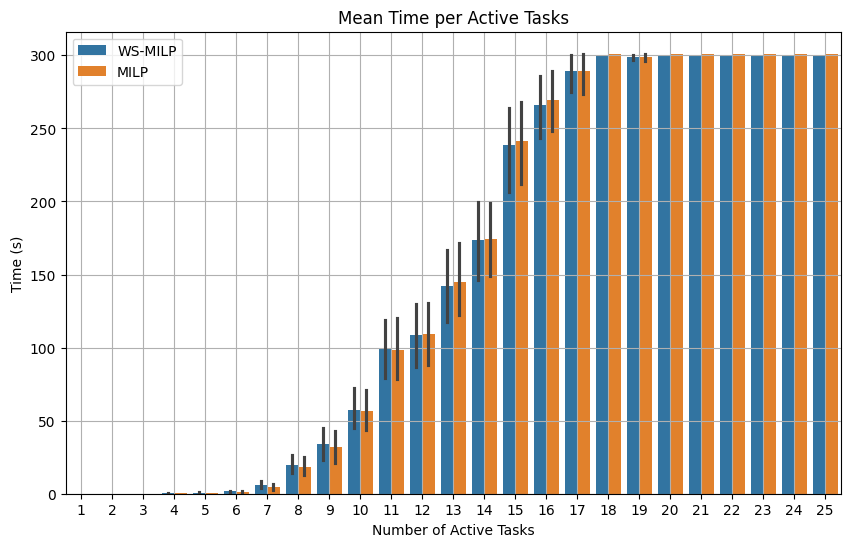

In [6]:
plot_bars_mean_times_by_active_tasks(ws_df, active_tasks_col='active_tasks', ws_time_col='MILP_time', milp_time_col='MILP_time_without_ws', figsize=(10, 6), estimator='mean', errorbar=('ci', 95))

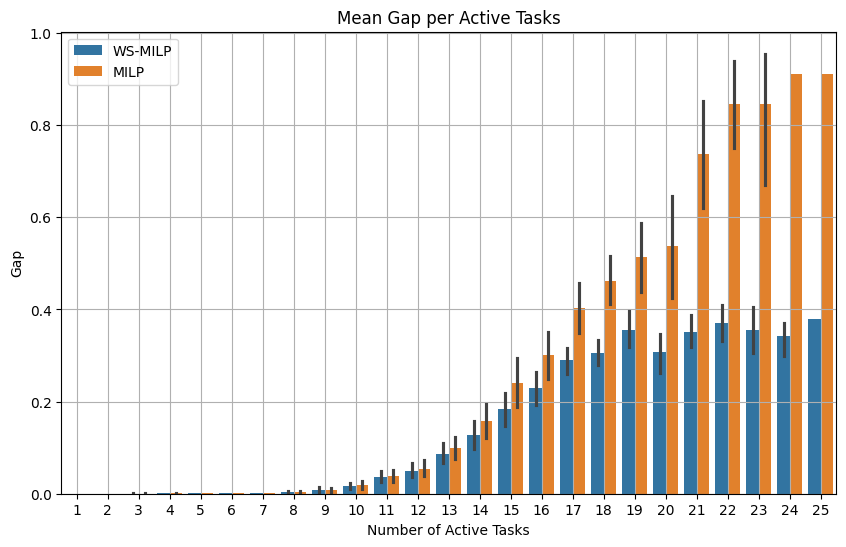

In [7]:
plot_df = (
        ws_df[['active_tasks', 'MILP_gap', 'gap_MILP_without_ws']]
            .rename(columns={
                'active_tasks': 'Active Tasks',
                'MILP_gap': 'WS-MILP',
                'gap_MILP_without_ws': 'MILP'
            })
            .melt(
                id_vars='Active Tasks',
                var_name='Method',
                value_name='Gap'
            )
        )



plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df,
            x='Active Tasks', 
            y='Gap', 
            hue='Method',   
            estimator='mean', # 'mean' : mediana, 'median' - mediana
            errorbar=('ci', 95) # ('pi', 100) - min–max # 'sd' - desviacion estandar # ('ci', 95) -Intervalo de confianza del 95 % de la media)
)
plt.title(f"Mean Gap per Active Tasks")
plt.xlabel('Number of Active Tasks')
plt.ylabel('Gap')
plt.legend()
plt.grid()
plt.show()

In [8]:
#Count the number of rows where ws_iterations_df["no_milp_solution"] is True
no_solution = sum(ws_df["no_milp_solution"])
print(f"Number of iterations with no MILP solution: {no_solution} / {len(ws_df)}")

Number of iterations with no MILP solution: 136 / 2999


In [9]:
# I need a pandas dataframe with columns: active_tasks, no_milp_solution, and count, where count is the number of rows where active_tasks appears
grouped_df = ws_df.groupby("active_tasks").agg(
    no_milp_solution_sum=("no_milp_solution", "sum"),
    count=("no_milp_solution", "size")
).reset_index()
grouped_df

,active_tasks,no_milp_solution_sum,count
0,1,0,135
1,2,0,143
2,3,0,208
3,4,0,265
4,5,0,263
5,6,0,263
6,7,0,272
7,8,0,249
8,9,0,191
9,10,0,186
